In [1]:
import os

import lucem_illud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.neural_network
import sklearn.tree
from IPython.display import display
from transformers import pipeline

%matplotlib inline

# Constants, Utility Functions, and Data Importing

In [29]:
# Constants
NOISE = 0.2
TEST_SPLIT = 0.2
NUM_PER_CATEGORY = 750

In [69]:
# Utility Functions


def calc_f_measure(
    true_pos: int, false_pos: int, true_neg: int, false_neg: int
) -> None:
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)

    f_measure = (2 * precision * recall) / (precision + recall)
    print(f"F-measure: {f_measure}")


def pca_split_stats(
    test_df: pd.DataFrame,
    train_df: pd.DataFrame,
    red_pca_key: str,
    category_key: str = "category",
    dimensions: int = 10,
) -> None:
    logistic = sklearn.linear_model.LogisticRegression()
    train_df[red_pca_key] = train_df["pca"].apply(lambda x: x[:dimensions])
    test_df[red_pca_key] = test_df["pca"].apply(lambda x: x[:dimensions])

    logistic.fit(np.stack(train_df[red_pca_key], axis=0), train_df[category_key])

    print(f"Linear Regression stats for {dimensions} dimensions")
    print("Training:")
    print(
        logistic.score(np.stack(train_df[red_pca_key], axis=0), train_df[category_key])
    )
    print("Testing:")
    print(logistic.score(np.stack(test_df[red_pca_key], axis=0), test_df[category_key]))


def classifier_evaluation(
    train_df: pd.DataFrame, test_df: pd.DataFrame
) -> (pd.DataFrame, pd.DataFrame):
    classifiers = [
        (sklearn.naive_bayes.GaussianNB(), "Gaussian"),
        (sklearn.svm.SVC(kernel="linear", probability=True), "Linear SVC"),
        (
            sklearn.svm.SVC(kernel="poly", degree=3, probability=True),
            "Poly SVC",
        ),
        (
            sklearn.neighbors.KNeighborsClassifier(5, weights="distance"),
            "KNN",
        ),
        (sklearn.linear_model.LogisticRegression(), "Logistic Regression"),
        (sklearn.tree.DecisionTreeClassifier(), "Decision Tree"),
        (sklearn.ensemble.RandomForestClassifier(), "Random Forest"),
        (sklearn.neural_network.MLPClassifier(), "MLP"),
        (sklearn.ensemble.GradientBoostingClassifier(), "Gradient Boosting"),
    ]

    cm_df = pd.DataFrame(
        columns=["Classifier", "True Pos", "False Pos", "True Neg", "False Neg"]
    )

    eval_df = pd.DataFrame(
        columns=[
            "Classifier",
            "Positive",
            "Error_Rate",
            "AUC",
            "Precision",
            "Average_Precision",
            "Recall",
        ]
    )

    for clf, name in classifiers:
        clf.fit(np.stack(train_df["vect"], axis=0), train_df["category"])
        df = lucem_illud.evaluateClassifier(clf, test_df)
        df["Classifier"] = name
        df["Positive"] = [s == 1 for s in df.index]
        predictions = clf.predict(np.stack(test_df["vect"], axis=0))
        mat = sklearn.metrics.confusion_matrix(test_df["category"], predictions)

        true_pos = mat[1][1]
        false_pos = mat[0][1]
        true_neg = mat[0][0]
        false_neg = mat[1][0]

        cm_df = pd.concat(
            [
                cm_df,
                pd.DataFrame(
                    [
                        {
                            "Classifier": name,
                            "True Pos": true_pos,
                            "False Pos": false_pos,
                            "True Neg": true_neg,
                            "False Neg": false_neg,
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )

        recall = true_pos / (true_pos + false_neg)
        precision = true_pos / (true_pos + false_pos)

        f_measure = (2 * precision * recall) / (precision + recall)
        print(f"F-measure for {name}: {f_measure}")

        eval_df = pd.concat([eval_df, df], ignore_index=True)
        # The below images were not generated due to it making it unreadable.
        # lucem_illud.plotConfusionMatrix(clf, test_df)
        # lucem_illud.plotMultiROC(clf, test_df)
        # lucem_illud.plotregions(clf, train_df)
    return cm_df, eval_df


def logistic_regression_visualizer(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(np.stack(lg_test_df["vect"], axis=0), df["category"])
    eval_df = lucem_illud.evaluateClassifier(clf, df)
    eval_df["Positive"] = [s == 1 for s in eval_df.index]
    predictions = clf.predict(np.stack(df["vect"], axis=0))
    mat = sklearn.metrics.confusion_matrix(df["category"], predictions)
    true_pos = mat[1][1]
    false_pos = mat[0][1]
    true_neg = mat[0][0]
    false_neg = mat[1][0]

    cm_df = pd.concat(
        [
            pd.DataFrame(columns=["True Pos", "False Pos", "True Neg", "False Neg"]),
            pd.DataFrame(
                [
                    {
                        "True Pos": true_pos,
                        "False Pos": false_pos,
                        "True Neg": true_neg,
                        "False Neg": false_neg,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)

    f_measure = (2 * precision * recall) / (precision + recall)
    print(f"F-measure: {f_measure}")

    eval_df = pd.concat(
        [
            pd.DataFrame(
                columns=[
                    "Positive",
                    "Error_Rate",
                    "AUC",
                    "Precision",
                    "Average_Precision",
                    "Recall",
                ]
            ),
            eval_df,
        ],
        ignore_index=True,
    )
    lucem_illud.plotConfusionMatrix(clf, df)
    lucem_illud.plotMultiROC(clf, df)

    return cm_df, eval_df

In [31]:
# Data is sourced from a personal project of mine you can find here:
# https://ucpd-incident-reporter-7cfdc3369124.herokuapp.com/
ucpd_feather_path = "data/fully_tokenized_ucpd_incidents.feather"
if os.path.isfile(ucpd_feather_path):
    ucpd_reports = pd.read_feather(ucpd_feather_path)
else:
    # WARNING: This step takes about 120 minutes, so don't run it unless you need to.
    ucpd_reports = pd.read_csv("data/incident_dump.csv")
    ucpd_reports["tokenized_text"] = ucpd_reports["comments"].apply(
        lucem_illud.word_tokenize
    )
    ucpd_reports["normalized_text"] = ucpd_reports["tokenized_text"].apply(
        lucem_illud.normalizeTokens
    )
    ucpd_reports.to_feather(ucpd_feather_path)
ucpd_reports.head(50)

,comments,disposition,incident,location,occurred,predicted_incident,reported,reported_date,ucpd_id,validated_address,validated_location,tokenized_text,normalized_text
0,A person was transported to Comer Hospital by ...,Closed,Mental Health Transport,6300 S. University Ave. (S. Woodlawn Ave. Char...,2/1/24 10:10 AM,None,2024-02-01T10:10:00-06:00,2024-02-01,24-00114,"6300 S UNIVERSITY AVE, CHICAGO, IL, 60637","41.78045407997166,-87.59732203570559","[A, person, was, transported, to, Comer, Hospi...","[person, transport, comer, hospital, cfd, ems,..."
1,Catalytic converter taken from a 2015 Toyota p...,Open,Theft from Motor Vehicle,1210 E. 57th St. (Public Way),1/31/24 to 2/1/24 6:00 PM to 7:00 AM,None,2024-02-01T10:18:00-06:00,2024-02-01,24-00115,"1210 E 57TH ST, CHICAGO, IL, 60637","41.79150658678615,-87.59602168542061","[Catalytic, converter, taken, from, a, 2015, T...","[catalytic, converter, take, toyota, park, str..."
2,Debit and credit cards taken from wallet in un...,Open,Theft,900 E. 57th St. (Knapp Center),2/1/24 9:50 AM to 4:30 PM,None,2024-02-01T17:54:00-06:00,2024-02-01,24-00116,"900 E 57TH ST, CHICAGO, IL, 60637","41.791423455510476,-87.60366291896175","[Debit, and, credit, cards, taken, from, walle...","[debit, credit, card, take, wallet, unattended..."
3,Boyfriend battered girlfriend in off-campus pr...,Open,Domestic Battery,6040 S. Harper Ave. (Apt. Building),2/1/24 2:45 PM,None,2024-02-01T15:45:00-06:00,2024-02-01,24-00117,"6040 S HARPER AVE, CHICAGO, IL, 60637","41.78472618578524,-87.58821677767634","[Boyfriend, battered, girlfriend, in, off, cam...","[boyfriend, batter, girlfriend, campus, privat..."
4,A known suspect entered the off-campus store a...,Referred,Information / Theft,1346 E. 53rd St. (Target),1/31/24 12:15 PM,None,2024-01-31T14:16:00-06:00,2024-01-31,2024-004118,"1346 E 53RD ST, CHICAGO, IL, 60615","41.79955044222366,-87.593062823983","[A, known, suspect, entered, the, off, campus,...","[know, suspect, enter, campus, store, take, me..."
5,Person found a social security card on the str...,Closed,Found Property,5800 S. Ellis Ave. (Public Way),1/31/24 12:10 PM,None,2024-01-31T12:10:00-06:00,2024-01-31,24-00113,"5800 S ELLIS AVE, CHICAGO, IL, 60637","41.78955246628657,-87.60133694890986","[Person, found, a, social, security, card, on,...","[person, find, social, security, card, street,..."
6,Window smashed and tools taken from van parked...,Referred,Information / Theft,1522 E. 59th St. (Public Way),1/30/24 8:00 AM to 9:15 AM,None,2024-01-30T09:35:00-06:00,2024-01-30,2024-003951,"1522 E 59TH ST, CHICAGO, IL, 60637","41.787940677385954,-87.5883629192693","[Window, smashed, and, tools, taken, from, van...","[window, smash, tool, take, van, park, street,..."
7,Unknown person(s) forced entry to victim's off...,CPD,Information / Burglary,S. Kenwood Ave. between E. 56th St. and E. 57t...,1/30/24 7:30 AM to 8:30 PM,None,2024-01-30T20:33:00-06:00,2024-01-30,2024-004004,"and South Kenwood Avenue, between, IL 60637","41.7912193,-87.6067356","[Unknown, person(s, forced, entry, to, victim,...","[unknown, person(s, force, entry, victim, camp..."
8,Unknown person attempted to enter victim's off...,CPD,Information / Attempted Burglary,S. Kimbark Ave. between E. 53rd St. and E. 54t...,1/30/24 8:15 PM,None,2024-01-30T20:46:00-06:00,2024-01-30,2024-004007,"between E. 53rd St. and, S. Kimbark Ave, Chica...","41.7980034,-87.5941627","[Unknown, person, attempted, to, enter, victim...","[unknown, person, attempt, enter, victim, camp..."
9,Victim walking in the crosswalk was struck by ...,Open,Traffic Crash / Hit and Run / Personal Injury,5500 S. Ingleside Ave. (Public Way),1/30/24 7:40 AM,None,2024-01-30T07:47:00-06:00,2024-01-30,24-00105,"5500 South Ingleside Avenue, Chicago, IL 60615...","41.7956509,-87.6030342","[Victim, walking, in, the, crosswalk, was, str...","[victim, walk, crosswalk, strike, unknown, veh..."


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at 
least 3 people evaluate and code each piece of content, using Amazon Mechanical 
Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  
With the resulting data, calculate, visualize and discuss inter-coder agreement or 
co-variation with appropriate metrics. What does this mean for the reliability of 
human assessments regarding content in your domain?

I wasn't able to get the manual coding done in time. That being said, I intended on
using the above comment UCPD reports dataset to see if the language was perceived as
neutral or otherwise. Some potential complications for this process are each categorizing
individuals' perspective on the content of the comment potentially assigning an intent
of the 'comment' field when none technically existed. To navigate around this, I imagine
it would be best to use multiple reviewers and use some enum like integer so that you
could effectively average results together and use that as your true metric.

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all the cells above and generate 10 distinct 
artificial datasets and classify them with all the available methods. Add a cell 
immediately below and describe which classifier(s) worked best with which 
artificially constructed data source and why. Then go through all the empirical 
datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify 
them with all available methods. Add a second cell immediately below and describe 
which classifier(s) worked best with which data set and why.

### Generated Datasets

In [38]:
# Dataset 1
ds1_cm, ds1_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.random(), test_size=TEST_SPLIT
    )
)
display(ds1_cm, ds1_eval)

F-measure for Gaussian: 0.5272727272727272
F-measure for Linear SVC: 0.543778801843318
F-measure for Poly SVC: 0.5806451612903226
F-measure for KNN: 0.5488372093023256
F-measure for Logistic Regression: 0.5092592592592592
F-measure for Decision Tree: 0.4694835680751174
F-measure for Random Forest: 0.48780487804878053
F-measure for MLP: 0.4734299516908212
F-measure for Gradient Boosting: 0.5267857142857143


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,58,66,38,38
1,Linear SVC,59,62,42,37
2,Poly SVC,72,80,24,24
3,KNN,59,60,44,37
4,Logistic Regression,55,65,39,41
5,Decision Tree,50,67,37,46
6,Random Forest,50,59,45,46
7,MLP,49,62,42,47
8,Gradient Boosting,59,69,35,37


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.520,0.484776,0.500000,0.512692,0.365385
1,Gaussian,True,0.520,0.484776,0.467742,0.472594,0.604167
2,Linear SVC,False,0.495,0.509215,0.531646,0.524703,0.403846
3,Linear SVC,True,0.495,0.509215,0.487603,0.484673,0.614583
4,Poly SVC,False,0.520,0.490385,0.500000,0.515385,0.230769
5,Poly SVC,True,0.520,0.490385,0.473684,0.475263,0.750000
6,KNN,False,0.485,0.518830,0.543210,0.529820,0.423077
7,KNN,True,0.485,0.518830,0.495798,0.489709,0.614583
8,Logistic Regression,False,0.530,0.473958,0.487500,0.507812,0.375000
9,Logistic Regression,True,0.530,0.473958,0.458333,0.467587,0.572917


In [39]:
# Dataset 2
ds2_cm, ds2_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.andSplit(NOISE), test_size=TEST_SPLIT
    )
)
display(ds2_cm, ds2_eval)

F-measure for Gaussian: 0.8944723618090452
F-measure for Linear SVC: 0.9
F-measure for Poly SVC: 0.8648648648648649
F-measure for KNN: 0.8844221105527639
F-measure for Logistic Regression: 0.8944723618090452
F-measure for Decision Tree: 0.8921568627450981
F-measure for Random Forest: 0.898989898989899
F-measure for MLP: 0.8944723618090452
F-measure for Gradient Boosting: 0.89


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,89,8,90,13
1,Linear SVC,90,8,90,12
2,Poly SVC,80,3,95,22
3,KNN,88,9,89,14
4,Logistic Regression,89,8,90,13
5,Decision Tree,91,11,87,11
6,Random Forest,89,7,91,13
7,MLP,89,8,90,13
8,Gradient Boosting,89,9,89,13


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.105,0.895458,0.873786,0.842457,0.918367
1,Gaussian,True,0.105,0.895458,0.917526,0.865586,0.872549
2,Linear SVC,False,0.100,0.900360,0.882353,0.850324,0.918367
3,Linear SVC,True,0.100,0.900360,0.918367,0.870324,0.882353
4,Poly SVC,False,0.125,0.876851,0.811966,0.802110,0.969388
5,Poly SVC,True,0.125,0.876851,0.963855,0.865965,0.784314
6,KNN,False,0.115,0.885454,0.864078,0.829724,0.908163
7,KNN,True,0.115,0.885454,0.907216,0.852697,0.862745
8,Logistic Regression,False,0.105,0.895458,0.873786,0.842457,0.918367
9,Logistic Regression,True,0.105,0.895458,0.917526,0.865586,0.872549


In [40]:
# Dataset 3
ds3_cm, ds3_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.xorSplit(NOISE), test_size=TEST_SPLIT
    )
)
display(ds3_cm, ds3_eval)

F-measure for Gaussian: 0.3186813186813187
F-measure for Linear SVC: 0.6200873362445415
F-measure for Poly SVC: 0.7844827586206897
F-measure for KNN: 0.8940092165898618
F-measure for Logistic Regression: 0.35294117647058826
F-measure for Decision Tree: 0.8663594470046083
F-measure for Random Forest: 0.892018779342723
F-measure for MLP: 0.8867924528301887
F-measure for Gradient Boosting: 0.897196261682243


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,29,45,47,79
1,Linear SVC,71,50,42,37
2,Poly SVC,91,33,59,17
3,KNN,97,12,80,11
4,Logistic Regression,33,46,46,75
5,Decision Tree,94,15,77,14
6,Random Forest,95,10,82,13
7,MLP,94,10,82,14
8,Gradient Boosting,96,10,82,12


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.620,0.389694,0.373016,0.415562,0.510870
1,Gaussian,True,0.620,0.389694,0.391892,0.500230,0.268519
2,Linear SVC,False,0.435,0.556965,0.531646,0.492708,0.456522
3,Linear SVC,True,0.435,0.556965,0.586777,0.570751,0.657407
4,Poly SVC,False,0.250,0.741948,0.776316,0.662855,0.641304
5,Poly SVC,True,0.250,0.741948,0.733871,0.703354,0.842593
6,KNN,False,0.115,0.883857,0.879121,0.824453,0.869565
7,KNN,True,0.115,0.883857,0.889908,0.854269,0.898148
8,Logistic Regression,False,0.605,0.402778,0.380165,0.420083,0.500000
9,Logistic Regression,True,0.605,0.402778,0.417722,0.502637,0.305556


In [41]:
# Dataset 4
ds4_cm, ds4_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.targetSplit(NOISE), test_size=TEST_SPLIT
    )
)
display(ds4_cm, ds4_eval)

F-measure for Gaussian: 0.8981481481481483
F-measure for Linear SVC: 0.5419354838709678
F-measure for Poly SVC: 0.22580645161290322
F-measure for KNN: 0.9174311926605504
F-measure for Logistic Regression: 0.574585635359116
F-measure for Decision Tree: 0.8949771689497716
F-measure for Random Forest: 0.8990825688073394
F-measure for MLP: 0.9107981220657277
F-measure for Gradient Boosting: 0.9032258064516129


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,97,9,81,13
1,Linear SVC,42,3,87,68
2,Poly SVC,14,0,90,96
3,KNN,100,8,82,10
4,Logistic Regression,52,19,71,58
5,Decision Tree,98,11,79,12
6,Random Forest,98,10,80,12
7,MLP,97,6,84,13
8,Gradient Boosting,98,9,81,12


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.110,0.890909,0.861702,0.820532,0.900000
1,Gaussian,True,0.110,0.890909,0.915094,0.871947,0.881818
2,Linear SVC,False,0.355,0.674242,0.561290,0.557581,0.966667
3,Linear SVC,True,0.355,0.674242,0.933333,0.696364,0.381818
4,Poly SVC,False,0.480,0.563636,0.483871,0.483871,1.000000
5,Poly SVC,True,0.480,0.563636,1.000000,0.607273,0.127273
6,KNN,False,0.090,0.910101,0.891304,0.852077,0.911111
7,KNN,True,0.090,0.910101,0.925926,0.891751,0.909091
8,Logistic Regression,False,0.385,0.630808,0.550388,0.529195,0.788889
9,Logistic Regression,True,0.385,0.630808,0.732394,0.636223,0.472727


In [42]:
# Dataset 5
ds5_cm, ds5_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.multiBlobs(NOISE), test_size=TEST_SPLIT
    )
)
display(ds5_cm, ds5_eval)

F-measure for Gaussian: 1.0
F-measure for Linear SVC: 1.0
F-measure for Poly SVC: 1.0
F-measure for KNN: 1.0
F-measure for Logistic Regression: 1.0
F-measure for Decision Tree: 1.0


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F-measure for Random Forest: 1.0


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F-measure for MLP: 1.0
F-measure for Gradient Boosting: 1.0


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,107,0,93,0
1,Linear SVC,107,0,93,0
2,Poly SVC,107,0,93,0
3,KNN,107,0,93,0
4,Logistic Regression,107,0,93,0
5,Decision Tree,107,0,93,0
6,Random Forest,107,0,93,0
7,MLP,107,0,93,0
8,Gradient Boosting,107,0,93,0


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.000,1.000000,1.000000,1.000000,1.000000
1,Gaussian,True,0.000,1.000000,1.000000,1.000000,1.000000
2,Gaussian,False,0.092,0.849781,0.741935,0.606566,0.758242
3,Gaussian,False,0.020,0.974411,0.947368,0.921534,0.964286
4,Gaussian,False,0.080,0.864265,0.806452,0.667545,0.773196
5,Linear SVC,False,0.000,1.000000,1.000000,1.000000,1.000000
6,Linear SVC,True,0.000,1.000000,1.000000,1.000000,1.000000
7,Linear SVC,False,0.090,0.855276,0.744681,0.614831,0.769231
8,Linear SVC,False,0.022,0.976298,0.931624,0.912670,0.973214
9,Linear SVC,False,0.080,0.856438,0.820225,0.665283,0.752577


In [43]:
# Dataset 6
ds6_cm, ds6_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.random(NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds6_cm, ds6_eval)

F-measure for Gaussian: 0.45588235294117646
F-measure for Linear SVC: 0.5000000000000001
F-measure for Poly SVC: 0.5192307692307693
F-measure for KNN: 0.4705882352941176
F-measure for Logistic Regression: 0.47586206896551725
F-measure for Decision Tree: 0.5359477124183005
F-measure for Random Forest: 0.49324324324324326
F-measure for MLP: 0.4126984126984127
F-measure for Gradient Boosting: 0.477815699658703


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,62,56,90,92
1,Linear SVC,75,71,75,79
2,Poly SVC,81,77,69,73
3,KNN,68,67,79,86
4,Logistic Regression,69,67,79,85
5,Decision Tree,82,70,76,72
6,Random Forest,73,69,77,81
7,MLP,52,46,100,102
8,Gradient Boosting,70,69,77,84


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.493333,0.509518,0.494505,0.491499,0.616438
1,Gaussian,True,0.493333,0.509518,0.525424,0.518201,0.402597
2,Linear SVC,False,0.500000,0.500356,0.487013,0.486845,0.513699
3,Linear SVC,True,0.500000,0.500356,0.513699,0.513511,0.487013
4,Poly SVC,False,0.500000,0.499288,0.485915,0.486312,0.472603
5,Poly SVC,True,0.500000,0.499288,0.512658,0.512978,0.525974
6,KNN,False,0.510000,0.491327,0.478788,0.482403,0.541096
7,KNN,True,0.510000,0.491327,0.503704,0.509081,0.441558
8,Logistic Regression,False,0.506667,0.494574,0.481707,0.483983,0.541096
9,Logistic Regression,True,0.506667,0.494574,0.507353,0.510654,0.448052


In [44]:
# Dataset 7
ds7_cm, ds7_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.andSplit(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds7_cm, ds7_eval)

F-measure for Gaussian: 0.9036544850498338
F-measure for Linear SVC: 0.9042904290429044
F-measure for Poly SVC: 0.9126213592233009
F-measure for KNN: 0.8974358974358975
F-measure for Logistic Regression: 0.9036544850498338
F-measure for Decision Tree: 0.8758169934640522
F-measure for Random Forest: 0.9032258064516129
F-measure for MLP: 0.8976897689768977
F-measure for Gradient Boosting: 0.8910891089108911


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,136,13,135,16
1,Linear SVC,137,14,134,15
2,Poly SVC,141,16,132,11
3,KNN,140,20,128,12
4,Logistic Regression,136,13,135,16
5,Decision Tree,134,20,128,18
6,Random Forest,140,18,130,12
7,MLP,136,15,133,16
8,Gradient Boosting,135,16,132,17


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.096667,0.903450,0.894040,0.858843,0.912162
1,Gaussian,True,0.096667,0.903450,0.912752,0.870006,0.894737
2,Linear SVC,False,0.096667,0.903361,0.899329,0.860924,0.905405
3,Linear SVC,True,0.096667,0.903361,0.907285,0.867750,0.901316
4,Poly SVC,False,0.090000,0.909762,0.923077,0.876618,0.891892
5,Poly SVC,True,0.090000,0.909762,0.898089,0.869763,0.927632
6,KNN,False,0.106667,0.892959,0.914286,0.857400,0.864865
7,KNN,True,0.106667,0.892959,0.875000,0.845921,0.921053
8,Logistic Regression,False,0.096667,0.903450,0.894040,0.858843,0.912162
9,Logistic Regression,True,0.096667,0.903450,0.912752,0.870006,0.894737


In [45]:
# Dataset 8
ds8_cm, ds8_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.xorSplit(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds8_cm, ds8_eval)

F-measure for Gaussian: 0.48632218844984804
F-measure for Linear SVC: 0.5454545454545454
F-measure for Poly SVC: 0.7433628318584071
F-measure for KNN: 0.9020979020979022
F-measure for Logistic Regression: 0.48466257668711654
F-measure for Decision Tree: 0.8888888888888888
F-measure for Random Forest: 0.8873239436619719
F-measure for MLP: 0.8958333333333334
F-measure for Gradient Boosting: 0.8896797153024911


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,80,105,51,64
1,Linear SVC,66,32,124,78
2,Poly SVC,126,69,87,18
3,KNN,129,13,143,15
4,Logistic Regression,79,103,53,65
5,Decision Tree,128,16,140,16
6,Random Forest,126,14,142,18
7,MLP,129,15,141,15
8,Gradient Boosting,125,12,144,19


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.563333,0.441239,0.443478,0.494983,0.326923
1,Gaussian,True,0.563333,0.441239,0.432432,0.453574,0.555556
2,Linear SVC,False,0.366667,0.626603,0.613861,0.594608,0.794872
3,Linear SVC,True,0.366667,0.626603,0.673469,0.568673,0.458333
4,Poly SVC,False,0.290000,0.716346,0.828571,0.692088,0.557692
5,Poly SVC,True,0.290000,0.716346,0.646154,0.625385,0.875000
6,KNN,False,0.093333,0.906250,0.905063,0.872975,0.916667
7,KNN,True,0.093333,0.906250,0.908451,0.863820,0.895833
8,Logistic Regression,False,0.560000,0.444177,0.449153,0.495930,0.339744
9,Logistic Regression,True,0.560000,0.444177,0.434066,0.454800,0.548611


In [46]:
# Dataset 9
ds9_cm, ds9_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.targetSplit(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds9_cm, ds9_eval)

F-measure for Gaussian: 0.888888888888889
F-measure for Linear SVC: 0.36
F-measure for Poly SVC: 0.24043715846994537
F-measure for KNN: 0.8634920634920634
F-measure for Logistic Regression: 0.425531914893617
F-measure for Decision Tree: 0.8703703703703703
F-measure for Random Forest: 0.8722741433021807
F-measure for MLP: 0.8794788273615636
F-measure for Gradient Boosting: 0.8881789137380192


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,136,9,130,25
1,Linear SVC,36,3,136,125
2,Poly SVC,22,0,139,139
3,KNN,136,18,121,25
4,Logistic Regression,50,24,115,111
5,Decision Tree,141,22,117,20
6,Random Forest,140,20,119,21
7,MLP,135,11,128,26
8,Gradient Boosting,139,13,126,22


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.113333,0.889986,0.838710,0.814405,0.935252
1,Gaussian,True,0.113333,0.889986,0.937931,0.875623,0.844720
2,Linear SVC,False,0.426667,0.601010,0.521073,0.519827,0.978417
3,Linear SVC,True,0.426667,0.601010,0.923077,0.623069,0.223602
4,Poly SVC,False,0.463333,0.568323,0.500000,0.500000,1.000000
5,Poly SVC,True,0.463333,0.568323,1.000000,0.599979,0.136646
6,KNN,False,0.143333,0.857612,0.828767,0.781445,0.870504
7,KNN,True,0.143333,0.857612,0.883117,0.829320,0.844720
8,Logistic Regression,False,0.450000,0.568949,0.508850,0.500991,0.827338
9,Logistic Regression,True,0.450000,0.568949,0.675676,0.579837,0.310559


In [47]:
# Dataset 10
ds10_cm, ds10_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.multiBlobs(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds10_cm, ds10_eval)

F-measure for Gaussian: 1.0
F-measure for Linear SVC: 1.0
F-measure for Poly SVC: 1.0
F-measure for KNN: 1.0
F-measure for Logistic Regression: 1.0
F-measure for Decision Tree: 1.0


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F-measure for Random Forest: 1.0
F-measure for MLP: 1.0
F-measure for Gradient Boosting: 1.0


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,142,0,140,0
1,Linear SVC,142,0,140,0
2,Poly SVC,142,0,140,0
3,KNN,141,0,140,0
4,Logistic Regression,142,0,140,0
5,Decision Tree,139,0,140,0
6,Random Forest,142,0,140,0
7,MLP,142,0,140,0
8,Gradient Boosting,142,0,140,0


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.001333,0.999180,0.992908,0.992908,1.000000
1,Gaussian,True,0.010667,0.982990,0.972603,0.951289,0.972603
2,Gaussian,False,0.000000,1.000000,1.000000,1.000000,1.000000
3,Gaussian,False,0.000000,1.000000,1.000000,1.000000,1.000000
4,Gaussian,False,0.012000,0.980985,0.974843,0.951046,0.968750
5,Linear SVC,False,0.001333,0.999180,0.992908,0.992908,1.000000
6,Linear SVC,True,0.010667,0.982990,0.972603,0.951289,0.972603
7,Linear SVC,False,0.000000,1.000000,1.000000,1.000000,1.000000
8,Linear SVC,False,0.000000,1.000000,1.000000,1.000000,1.000000
9,Linear SVC,False,0.012000,0.980985,0.974843,0.951046,0.968750


On average, I ended up getting the best performance out of the K-nearest neighbor
and Gradient Boosting models. Periodically, you'd see the more positive results from
the Linear Regression and Poly SVC models, but the ones mentioned in the first sentence
seemed to perform best overall. It feels a little anti-climactic since KNN models are
fairly basic with regard to the rest, sans Linear Regression, but it does speak to why
the model is so widely used in spite of the development of newer models.

### Empirical Datasets

In [88]:
cm_reddit, eval_reddit = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadReddit(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_reddit, eval_reddit)

Loading Reddit data
Converting to vectors


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


F-measure for Gaussian: 0.78
F-measure for Linear SVC: 0.9775280898876404
F-measure for Poly SVC: 0.9822485207100591
F-measure for KNN: 0.9308176100628931
F-measure for Logistic Regression: 0.9772727272727273
F-measure for Decision Tree: 0.9375
F-measure for Random Forest: 0.9828571428571428
F-measure for MLP: 0.983050847457627
F-measure for Gradient Boosting: 0.9942857142857142


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,39,7,51,15
1,Linear SVC,87,1,74,3
2,Poly SVC,83,1,67,2
3,KNN,74,3,70,8
4,Logistic Regression,86,1,73,3
5,Decision Tree,75,5,61,5
6,Random Forest,86,0,74,3
7,MLP,87,2,73,1
8,Gradient Boosting,87,0,72,1


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.146875,0.793061,0.689189,0.543649,0.680000
1,Gaussian,False,0.190625,0.852246,0.565891,0.545241,0.935897
2,Gaussian,False,0.190625,0.694928,0.795918,0.504273,0.433333
3,Gaussian,False,0.071875,0.881701,0.897059,0.760657,0.792208
4,Linear SVC,False,0.012500,0.987211,0.961039,0.951350,0.986667
5,Linear SVC,False,0.003125,0.993590,1.000000,0.990304,0.987179
6,Linear SVC,False,0.015625,0.978986,0.977528,0.954319,0.966667
7,Linear SVC,False,0.006250,0.991449,0.987013,0.977320,0.987013
8,Poly SVC,False,0.031250,0.942585,0.971014,0.892440,0.893333
9,Poly SVC,False,0.034375,0.933831,0.985507,0.890410,0.871795


In [25]:
# This dataset will NOT load. I get the following error every time I try and
# load it:
# The 'remove' parameter of fetch_20newsgroups must be an instance of 'tuple'. Got ['headers', 'footers', 'quotes'] instead.
cm_ng, eval_ng = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadNewsGroups(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_ng, eval_ng)

Loading data for: comp.sys.mac.hardware


InvalidParameterError: The 'remove' parameter of fetch_20newsgroups must be an instance of 'tuple'. Got ['headers', 'footers', 'quotes'] instead.

In [89]:
cm_senate, eval_senate = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadSenateSmall(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_senate, eval_senate)

Loading senate data
Converting to vectors


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


F-measure for Gaussian: 0.8095238095238094
F-measure for Linear SVC: 0.9959839357429718
F-measure for Poly SVC: 0.8181818181818181
F-measure for KNN: 0.7888446215139442
F-measure for Logistic Regression: 0.9754098360655737
F-measure for Decision Tree: 0.9959839357429718
F-measure for Random Forest: 1.0
F-measure for MLP: 0.9236947791164659
F-measure for Gradient Boosting: 1.0


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,102,25,192,23
1,Linear SVC,124,0,217,1
2,Poly SVC,90,5,212,35
3,KNN,99,27,190,26
4,Logistic Regression,119,0,217,6
5,Decision Tree,124,0,217,1
6,Random Forest,125,0,217,0
7,MLP,115,9,208,10
8,Gradient Boosting,125,0,217,0


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.140351,0.850396,0.803150,0.722622,0.816000
1,Gaussian,False,0.140351,0.850396,0.893023,0.863240,0.884793
2,Linear SVC,False,0.002924,0.996000,1.000000,0.994924,0.992000
3,Linear SVC,False,0.002924,0.996000,0.995413,0.995413,1.000000
4,Poly SVC,False,0.116959,0.848479,0.947368,0.784444,0.720000
5,Poly SVC,False,0.116959,0.848479,0.858300,0.853143,0.976959
6,KNN,False,0.154971,0.833788,0.785714,0.698309,0.792000
7,KNN,False,0.154971,0.833788,0.879630,0.849130,0.875576
8,Logistic Regression,False,0.017544,0.976000,1.000000,0.969544,0.952000
9,Logistic Regression,False,0.017544,0.976000,0.973094,0.973094,1.000000


In [90]:
cm_senate_l, eval_senate_l = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadSenateLarge(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_senate_l, eval_senate_l)

Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


F-measure for Gaussian: 0.6666666666666666
F-measure for Linear SVC: 0.9435665914221218
F-measure for Poly SVC: 0.6705882352941176
F-measure for KNN: 0.6971428571428572
F-measure for Logistic Regression: 0.9400921658986175
F-measure for Decision Tree: 1.0
F-measure for Random Forest: 0.9977426636568849
F-measure for MLP: 0.9317647058823529
F-measure for Gradient Boosting: 1.0


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,123,28,294,95
1,Linear SVC,209,12,312,13
2,Poly SVC,114,7,317,105
3,KNN,122,22,299,84
4,Logistic Regression,204,8,316,18
5,Decision Tree,222,0,322,0
6,Random Forest,221,0,324,1
7,MLP,198,10,314,19
8,Gradient Boosting,222,0,323,0


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.049936,0.766900,0.911111,0.536335,0.539474
1,Gaussian,False,0.058899,0.745686,0.955556,0.528624,0.494253
2,Gaussian,False,0.190781,0.732304,0.710983,0.520683,0.554054
3,Gaussian,False,0.058899,0.693034,0.933333,0.419301,0.388889
4,Gaussian,False,0.286812,0.741450,0.602459,0.585088,0.907407
5,Linear SVC,False,0.003841,0.980263,1.000000,0.964368,0.960526
6,Linear SVC,False,0.003841,0.982759,1.000000,0.969358,0.965517
7,Linear SVC,False,0.032010,0.959987,0.945701,0.906968,0.941441
8,Linear SVC,False,0.006402,0.965278,1.000000,0.936958,0.930556
9,Linear SVC,False,0.046095,0.955223,0.928571,0.909545,0.962963


In [91]:
cm_spam, eval_spam = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadSpam(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_spam, eval_spam)

Loading Spam
Loading Ham
Converting to vectors


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


F-measure for Gaussian: 0.6239316239316238
F-measure for Linear SVC: 0.5960264900662252
F-measure for Poly SVC: 0.5074626865671642
F-measure for KNN: 0.5637583892617449
F-measure for Logistic Regression: 0.41935483870967744
F-measure for Decision Tree: 0.7017543859649124
F-measure for Random Forest: 0.7169811320754718
F-measure for MLP: 0.6555555555555556
F-measure for Gradient Boosting: 0.35294117647058826


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,73,63,524,25
1,Linear SVC,45,8,579,53
2,Poly SVC,34,2,585,64
3,KNN,42,9,578,56
4,Logistic Regression,26,0,587,72
5,Decision Tree,60,13,574,38
6,Random Forest,57,4,583,41
7,MLP,59,23,564,39
8,Gradient Boosting,21,0,587,77


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.128467,0.818786,0.954463,0.943995,0.892675
1,Gaussian,False,0.128467,0.818786,0.536765,0.436331,0.744898
2,Linear SVC,False,0.089051,0.722778,0.916139,0.915332,0.986371
3,Linear SVC,False,0.089051,0.722778,0.849057,0.467245,0.459184
4,Poly SVC,False,0.096350,0.671766,0.901387,0.901235,0.996593
5,Poly SVC,False,0.096350,0.671766,0.944444,0.421095,0.346939
6,KNN,False,0.094891,0.706620,0.911672,0.910833,0.984668
7,KNN,False,0.094891,0.706620,0.823529,0.434693,0.428571
8,Logistic Regression,False,0.105109,0.632653,0.890744,0.890744,1.000000
9,Logistic Regression,False,0.105109,0.632653,1.000000,0.370416,0.265306


All the models appeared to struggle with mapping 'True Negatives' for the various
corpora. With regard to the classification abilities of the models, the Linear SVC models
appeared to work the best. Their error rates were incredibly low, and their precision
measurements were very high. Similarly, but not to the same degree, Gradient Boosting models
performed well. Based on the 'empirical data' trials, I would opt for using Linear SVC
or Gradient Boosting models for classification on complex corpora as opposed to the other
models.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression 
classification using training, testing and un-coded (i.e., data you didn't code by 
hand but want to use your model on) data from texts and hand-classifications 
associated with your final project (e.g., these could be crowd-sourced codes 
gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion 
matrix for training and testing sets. Calculate precision, recall, the F-measure, 
and AUC, then perform an ROC visualization. How do these classifiers perform? 
Extrapolate code from these models to all un-coded data.

In [49]:
ucpd_reports["UCPD_Reported"] = [d == "CPD" for d in ucpd_reports["disposition"]]
ucpd_reports["category"] = [r for r in ucpd_reports["UCPD_Reported"]]
ucpd_reports.head(50)

,comments,disposition,incident,location,occurred,predicted_incident,reported,reported_date,ucpd_id,validated_address,validated_location,tokenized_text,normalized_text,UCPD_Reported,category
0,A person was transported to Comer Hospital by ...,Closed,Mental Health Transport,6300 S. University Ave. (S. Woodlawn Ave. Char...,2/1/24 10:10 AM,None,2024-02-01T10:10:00-06:00,2024-02-01,24-00114,"6300 S UNIVERSITY AVE, CHICAGO, IL, 60637","41.78045407997166,-87.59732203570559","[A, person, was, transported, to, Comer, Hospi...","[person, transport, comer, hospital, cfd, ems,...",False,False
1,Catalytic converter taken from a 2015 Toyota p...,Open,Theft from Motor Vehicle,1210 E. 57th St. (Public Way),1/31/24 to 2/1/24 6:00 PM to 7:00 AM,None,2024-02-01T10:18:00-06:00,2024-02-01,24-00115,"1210 E 57TH ST, CHICAGO, IL, 60637","41.79150658678615,-87.59602168542061","[Catalytic, converter, taken, from, a, 2015, T...","[catalytic, converter, take, toyota, park, str...",False,False
2,Debit and credit cards taken from wallet in un...,Open,Theft,900 E. 57th St. (Knapp Center),2/1/24 9:50 AM to 4:30 PM,None,2024-02-01T17:54:00-06:00,2024-02-01,24-00116,"900 E 57TH ST, CHICAGO, IL, 60637","41.791423455510476,-87.60366291896175","[Debit, and, credit, cards, taken, from, walle...","[debit, credit, card, take, wallet, unattended...",False,False
3,Boyfriend battered girlfriend in off-campus pr...,Open,Domestic Battery,6040 S. Harper Ave. (Apt. Building),2/1/24 2:45 PM,None,2024-02-01T15:45:00-06:00,2024-02-01,24-00117,"6040 S HARPER AVE, CHICAGO, IL, 60637","41.78472618578524,-87.58821677767634","[Boyfriend, battered, girlfriend, in, off, cam...","[boyfriend, batter, girlfriend, campus, privat...",False,False
4,A known suspect entered the off-campus store a...,Referred,Information / Theft,1346 E. 53rd St. (Target),1/31/24 12:15 PM,None,2024-01-31T14:16:00-06:00,2024-01-31,2024-004118,"1346 E 53RD ST, CHICAGO, IL, 60615","41.79955044222366,-87.593062823983","[A, known, suspect, entered, the, off, campus,...","[know, suspect, enter, campus, store, take, me...",False,False
5,Person found a social security card on the str...,Closed,Found Property,5800 S. Ellis Ave. (Public Way),1/31/24 12:10 PM,None,2024-01-31T12:10:00-06:00,2024-01-31,24-00113,"5800 S ELLIS AVE, CHICAGO, IL, 60637","41.78955246628657,-87.60133694890986","[Person, found, a, social, security, card, on,...","[person, find, social, security, card, street,...",False,False
6,Window smashed and tools taken from van parked...,Referred,Information / Theft,1522 E. 59th St. (Public Way),1/30/24 8:00 AM to 9:15 AM,None,2024-01-30T09:35:00-06:00,2024-01-30,2024-003951,"1522 E 59TH ST, CHICAGO, IL, 60637","41.787940677385954,-87.5883629192693","[Window, smashed, and, tools, taken, from, van...","[window, smash, tool, take, van, park, street,...",False,False
7,Unknown person(s) forced entry to victim's off...,CPD,Information / Burglary,S. Kenwood Ave. between E. 56th St. and E. 57t...,1/30/24 7:30 AM to 8:30 PM,None,2024-01-30T20:33:00-06:00,2024-01-30,2024-004004,"and South Kenwood Avenue, between, IL 60637","41.7912193,-87.6067356","[Unknown, person(s, forced, entry, to, victim,...","[unknown, person(s, force, entry, victim, camp...",True,True
8,Unknown person attempted to enter victim's off...,CPD,Information / Attempted Burglary,S. Kimbark Ave. between E. 53rd St. and E. 54t...,1/30/24 8:15 PM,None,2024-01-30T20:46:00-06:00,2024-01-30,2024-004007,"between E. 53rd St. and, S. Kimbark Ave, Chica...","41.7980034,-87.5941627","[Unknown, person, attempted, to, enter, victim...","[unknown, person, attempt, enter, victim, camp...",True,True
9,Victim walking in the crosswalk was struck by ...,Open,Traffic Crash / Hit and Run / Personal Injury,5500 S. Ingleside Ave. (Public Way),1/30/24 7:40 AM,None,2024-01-30T07:47:00-06:00,2024-01-30,24-00105,"5500 South Ingleside Avenue, Chicago, IL 60615...","41.7956509,-87.6030342","[Victim, walking, in, the, crosswalk, was, str...","[victim, walk, crosswalk, strike, 

In [54]:
# Create general variables
lg_train_df, lg_test_df = sklearn.model_selection.train_test_split(
    ucpd_reports, test_size=TEST_SPLIT
)
tf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_df=100, min_df=2, stop_words="english", norm="l2"
)
ucpd_pca = sklearn.decomposition.PCA()

# Apply vectors to training and test
tf_vectors_train = tf_vectorizer.fit_transform(lg_train_df["comments"])
lg_train_df["vectors"] = [np.array(v).flatten() for v in tf_vectors_train.todense()]
lg_train_df["vect"] = [r for r in lg_train_df["vectors"]]

tf_vectors_test = tf_vectorizer.fit_transform(lg_test_df["comments"])
lg_test_df["vectors"] = [np.array(v).flatten() for v in tf_vectors_test.todense()]
lg_test_df["vect"] = [r for r in lg_test_df["vectors"]]

reduced_data_train = ucpd_pca.fit_transform(np.stack(lg_train_df["vectors"], axis=0))
lg_train_df["pca"] = [r for r in reduced_data_train]

reduced_data_test = ucpd_pca.fit_transform(np.stack(lg_test_df["vectors"], axis=0))
lg_test_df["pca"] = [r for r in reduced_data_test]

/var/folders/67/q6s_d9w52v540n1lkmrr2k740000gn/T/ipykernel_7198/2292061046.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[0], label="True")
/var/folders/67/q6s_d9w52v540n1lkmrr2k740000gn/T/ipykernel_7198/2292061046.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[1], label="False")


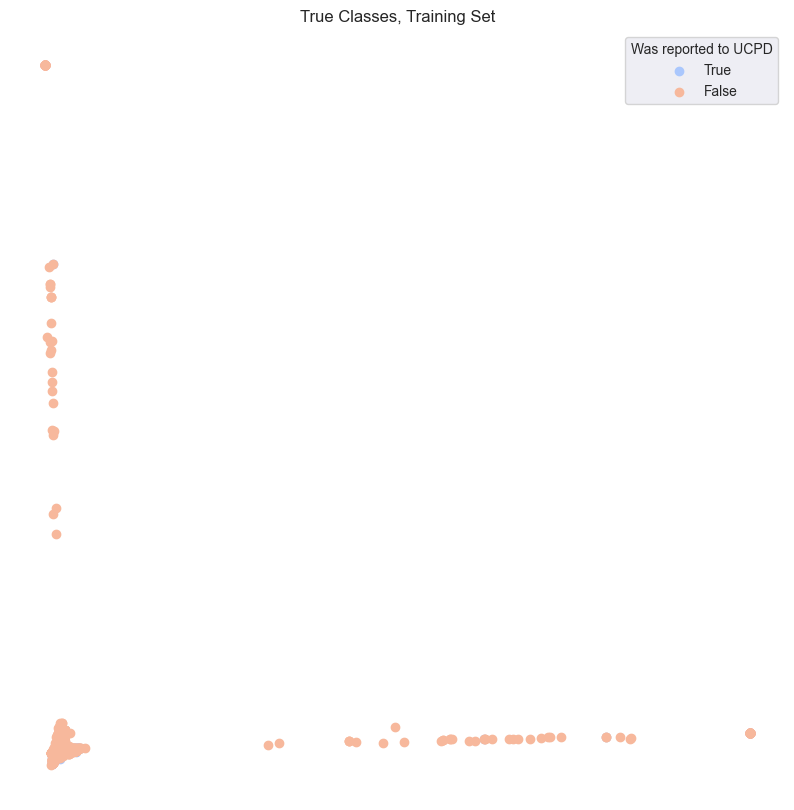

In [55]:
vis_fig, vis_ax = plt.subplots(figsize=(10, 10))
vis_ax.axis("off")
pallet = seaborn.color_palette(palette="coolwarm", n_colors=2)

# Plot UCPD_Reported
a = np.stack(lg_train_df[lg_train_df["UCPD_Reported"]]["pca"])
vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[0], label="True")

# Plot not UCPD_Reported
a = np.stack(lg_train_df[lg_train_df["UCPD_Reported"].eq(False)]["pca"])
vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[1], label="False")

vis_ax.legend(loc="upper right", title="Was reported to UCPD")
plt.title("True Classes, Training Set")
plt.show()

The 2D representation of the PCA analysis does not show a significant visual
separation between the `true` and `false`-ly designated rows.

In [56]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_10", "UCPD_Reported", 10)

Linear Regression stats for 10 dimensions
Training:
0.8525455221107395
Testing:
0.8400713436385255


In [57]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_15", "UCPD_Reported", 15)

Linear Regression stats for 15 dimensions
Training:
0.8493496841322928
Testing:
0.820154577883472


In [58]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_25", "UCPD_Reported", 25)

Linear Regression stats for 25 dimensions
Training:
0.8666666666666667
Testing:
0.7963733650416172


In [59]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_50", "UCPD_Reported", 50)

Linear Regression stats for 50 dimensions
Training:
0.8677814938684504
Testing:
0.8008323424494649


In [60]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_50", "UCPD_Reported", 75)

Linear Regression stats for 75 dimensions
Training:
0.8692679301374954
Testing:
0.7999405469678954


In [61]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_100", "UCPD_Reported", 100)

Linear Regression stats for 100 dimensions
Training:
0.8715719063545151
Testing:
0.7957788347205708


In [62]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_200", "UCPD_Reported", 200)

Linear Regression stats for 200 dimensions
Training:
0.8772946859903382
Testing:
0.7954815695600476


F-measure: 0.5211640211640212


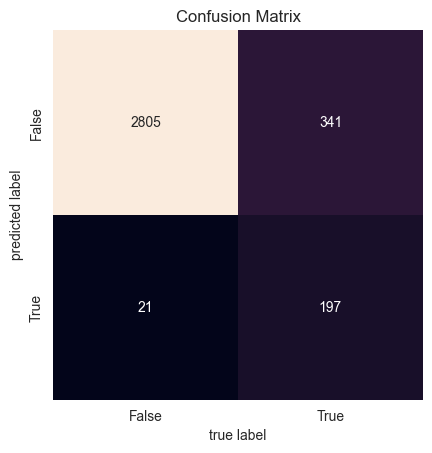

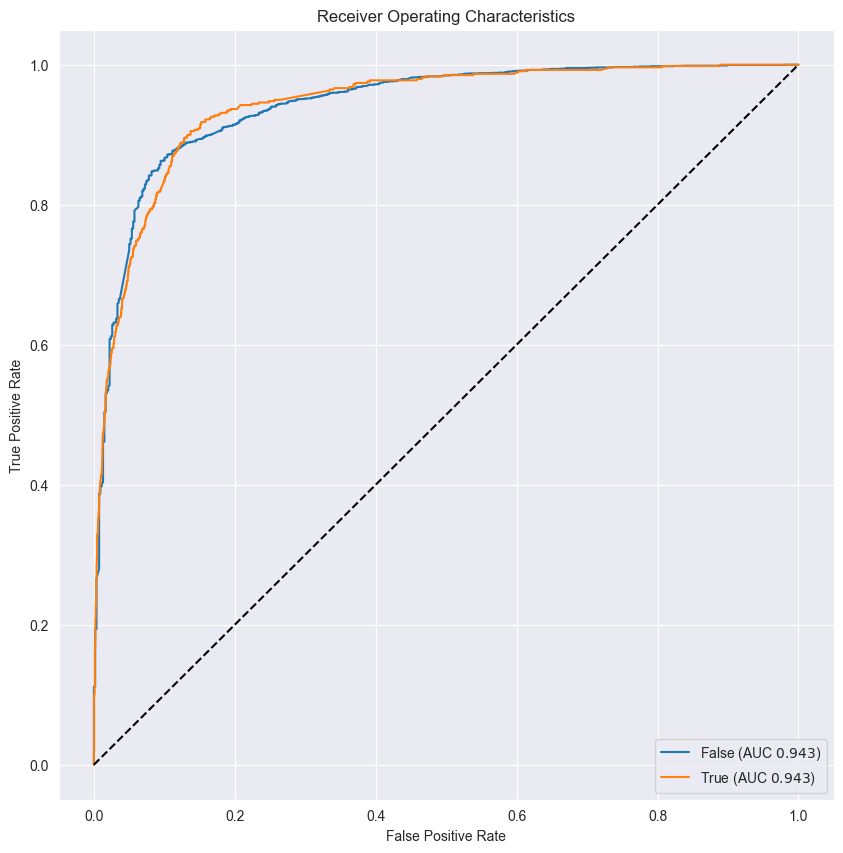

,True Pos,False Pos,True Neg,False Neg
0,197,21,2805,341


,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,False,0.10761,0.67937,0.891608,0.891225,0.992569
1,True,0.10761,0.67937,0.903670,0.432265,0.366171


In [63]:
lg_cm_df, lg_eval_df = logistic_regression_visualizer(lg_test_df)
display(lg_cm_df, lg_eval_df)

Based on the incredibly high AUC values for `true` and `false`, it does not appear that the
`comment` field values have any meaningful effect on the CPD reporting status of a given
incident. The Confusion Matrix confirms this as well, with `true` incidents being twice as
likely to be categorized as `false` than their actual value. Within this context,
linear regression does not appear to an effective prediction solution.

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and 
random forest classification (binary, multinomial or continuous) using training, 
testing and extrapolation (un-coded) data from texts and hand-classifications 
associated with your final project. As with ***Exercise 2***, these could be 
crowdsourced codes gathered through Amazon Mechanical Turk last week. Visualize 
the classification of data points. Calculate relevant metrics (e.g., precision, 
recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees 
into a random forest. Visualize the result. How do these classifiers perform? 
What does ensemble learning do?

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


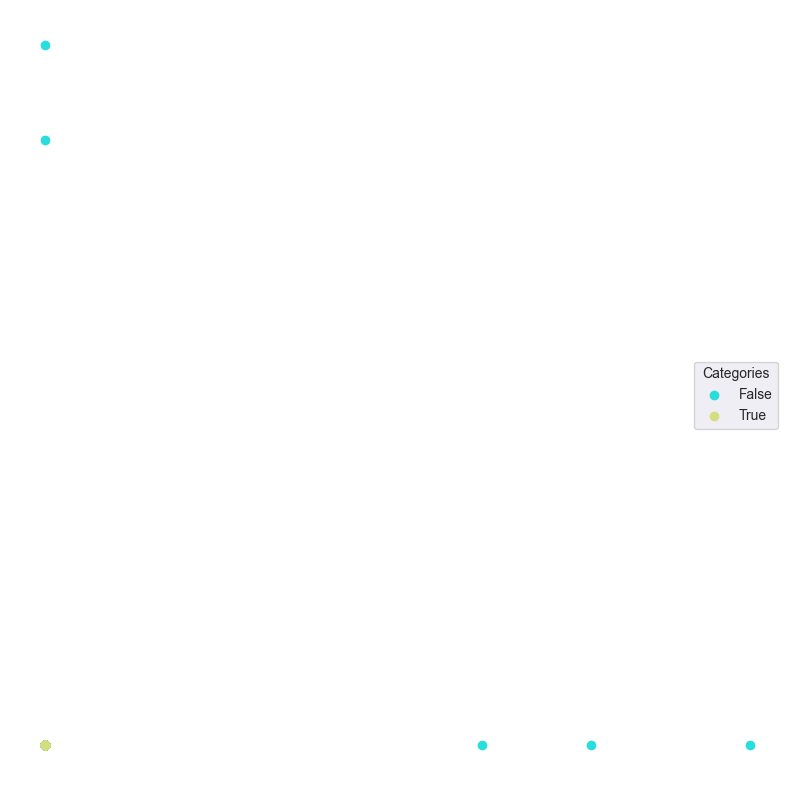

In [64]:
dt_train_df, dt_test_df = sklearn.model_selection.train_test_split(
    ucpd_reports, test_size=TEST_SPLIT
)
dt_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_df=100, min_df=2, stop_words="english", norm="l2"
)

# Apply vectors to training and test
dt_vectors_train = dt_vectorizer.fit_transform(dt_train_df["comments"])
dt_train_df["vect"] = [np.array(v).flatten() for v in dt_vectors_train.todense()]

dt_vectors_test = dt_vectorizer.fit_transform(dt_test_df["comments"])
dt_test_df["vect"] = [np.array(v).flatten() for v in dt_vectors_test.todense()]

lucem_illud.plotter(dt_train_df)

In [65]:
clf_dt = sklearn.tree.DecisionTreeClassifier(max_depth=4)
clf_bag = sklearn.ensemble.BaggingClassifier(clf_dt, n_estimators=100, max_samples=0.8)
clf_bag.fit(np.stack(dt_train_df["vect"], axis=0), dt_train_df["category"])

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                  max_samples=0.8, n_estimators=100)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


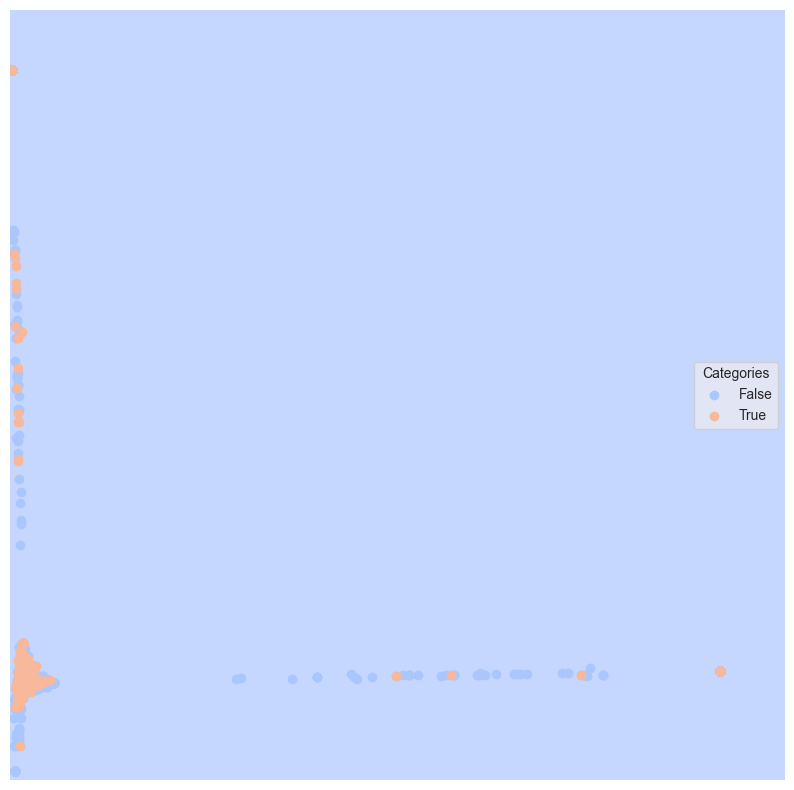

In [66]:
lucem_illud.plotregions(clf_bag, dt_train_df)

In [67]:
# I BELIEVE, I'm supposed to use the test data here, but it consistently
# returned an error message regarding the dimensions. Due to my inability
# to get past that, I used the training DataFrame.
lucem_illud.evaluateClassifier(clf_bag, dt_train_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.133928,0.558979,0.864601,0.864580,0.998687
True,0.133928,0.558979,0.941634,0.245122,0.119271


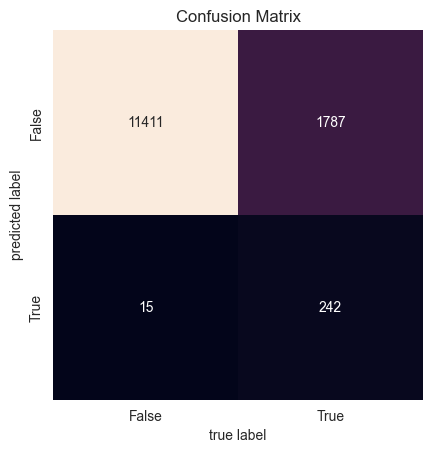

In [68]:
# I BELIEVE, I'm supposed to use the test data here, but it consistently
# returned an error message regarding the dimensions. Due to my inability
# to get past that, I used the training DataFrame.
lucem_illud.plotConfusionMatrix(clf_bag, dt_train_df)

In [77]:
# F-Measure
calc_f_measure(242, 15, 11411, 1787)

F-measure: 0.21172353455818024


The Decision Tree model with Bagging appears to perform far worse than
the logistic regression model, with the approximate rate of false negatives
being 9 for every 1 true positive as shown by the Confusion Matrix. This
inability to accurately predict if something was reported to CPD is
reinforced in the  

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network 
classification and calculate relevant metrics (e.g., precision, recall, the 
F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, 
logistic and decision-tree approaches?

In [72]:
# Using the testing and training splits from Exercise 5.
nn_clf = sklearn.neural_network.MLPClassifier()
nn_clf.fit(np.stack(dt_train_df["vect"], axis=0), dt_train_df["category"])

MLPClassifier()

In [73]:
# I BELIEVE, I'm supposed to use the test data here, but it consistently
# returned an error message regarding the dimensions. Due to my inability
# to get past that, I used the training DataFrame.
lucem_illud.evaluateClassifier(nn_clf, dt_train_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.047417,0.865478,0.955574,0.954532,0.990198
True,0.047417,0.865478,0.930650,0.728481,0.740759


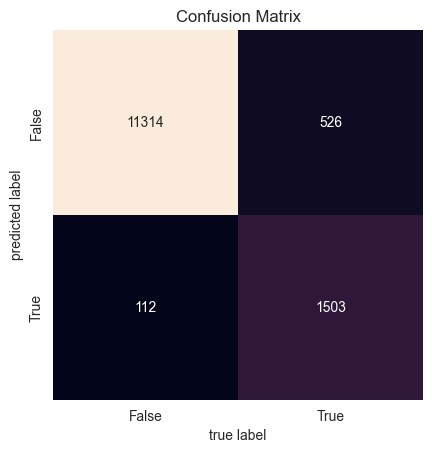

In [74]:
# I BELIEVE, I'm supposed to use the test data here, but it consistently
# returned an error message regarding the dimensions. Due to my inability
# to get past that, I used the training DataFrame.
lucem_illud.plotConfusionMatrix(nn_clf, dt_train_df)

In [80]:
# F-Measure
calc_f_measure(1503, 112, 11314, 526)

F-measure: 0.8249176728869374


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


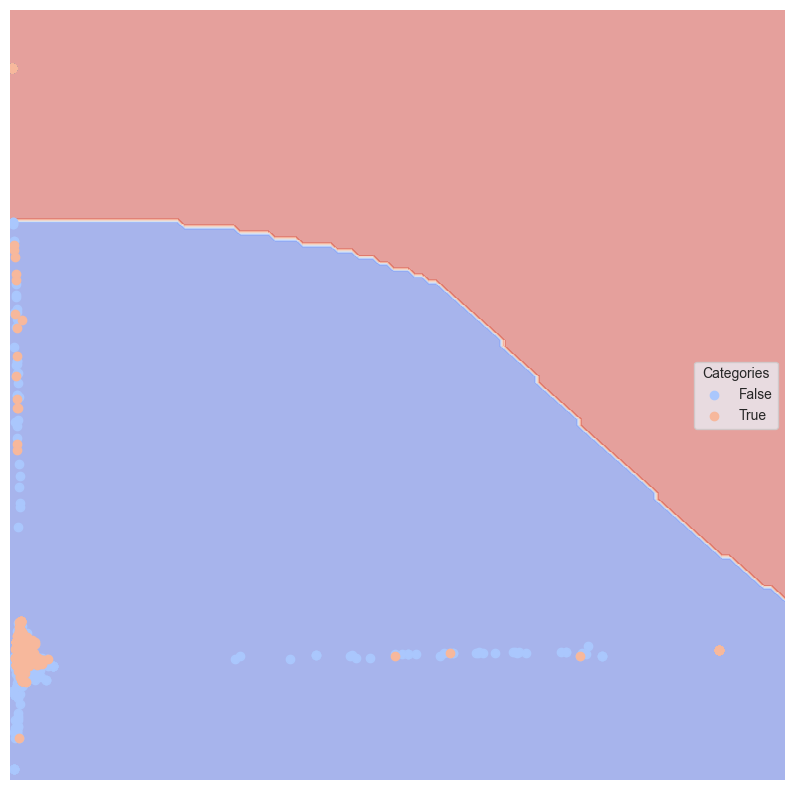

In [81]:
lucem_illud.plotregions(nn_clf, dt_train_df)

By all cited metrics, the neural network classification is far more effective at the task of
accurately categorizing whether an incident is referenced to CPD. This shows in the increased likelihood
of something being categorized in the Confusion Matrix, the higher F-measure, lower Error Rate, etc.
Most notably, the neural network classifier gives us a intelligible region plot, which has not been
the case for the rest of the classifiers.

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions 
or the word or sentence vector functions (e.g., similarity) to explore the social 
game underlying the production and meaning of texts associated with your final project. 
How does BERT help you gain insight regarding your research question that is similar 
and different from prior methods?

In [84]:
# Using a sentiment analyzer that also includes a neutral tag.
nlp_pipeline = pipeline(
    "sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis"
)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [85]:
ucpd_reports["Sentiment"] = ucpd_reports["comments"].apply(
    lambda x: nlp_pipeline(x)[0]["label"]
)

In [86]:
ucpd_reports.head(50)

,comments,disposition,incident,location,occurred,predicted_incident,reported,reported_date,ucpd_id,validated_address,validated_location,tokenized_text,normalized_text,UCPD_Reported,category,Sentiment
0,A person was transported to Comer Hospital by ...,Closed,Mental Health Transport,6300 S. University Ave. (S. Woodlawn Ave. Char...,2/1/24 10:10 AM,None,2024-02-01T10:10:00-06:00,2024-02-01,24-00114,"6300 S UNIVERSITY AVE, CHICAGO, IL, 60637","41.78045407997166,-87.59732203570559","[A, person, was, transported, to, Comer, Hospi...","[person, transport, comer, hospital, cfd, ems,...",False,False,NEU
1,Catalytic converter taken from a 2015 Toyota p...,Open,Theft from Motor Vehicle,1210 E. 57th St. (Public Way),1/31/24 to 2/1/24 6:00 PM to 7:00 AM,None,2024-02-01T10:18:00-06:00,2024-02-01,24-00115,"1210 E 57TH ST, CHICAGO, IL, 60637","41.79150658678615,-87.59602168542061","[Catalytic, converter, taken, from, a, 2015, T...","[catalytic, converter, take, toyota, park, str...",False,False,NEU
2,Debit and credit cards taken from wallet in un...,Open,Theft,900 E. 57th St. (Knapp Center),2/1/24 9:50 AM to 4:30 PM,None,2024-02-01T17:54:00-06:00,2024-02-01,24-00116,"900 E 57TH ST, CHICAGO, IL, 60637","41.791423455510476,-87.60366291896175","[Debit, and, credit, cards, taken, from, walle...","[debit, credit, card, take, wallet, unattended...",False,False,NEU
3,Boyfriend battered girlfriend in off-campus pr...,Open,Domestic Battery,6040 S. Harper Ave. (Apt. Building),2/1/24 2:45 PM,None,2024-02-01T15:45:00-06:00,2024-02-01,24-00117,"6040 S HARPER AVE, CHICAGO, IL, 60637","41.78472618578524,-87.58821677767634","[Boyfriend, battered, girlfriend, in, off, cam...","[boyfriend, batter, girlfriend, campus, privat...",False,False,NEG
4,A known suspect entered the off-campus store a...,Referred,Information / Theft,1346 E. 53rd St. (Target),1/31/24 12:15 PM,None,2024-01-31T14:16:00-06:00,2024-01-31,2024-004118,"1346 E 53RD ST, CHICAGO, IL, 60615","41.79955044222366,-87.593062823983","[A, known, suspect, entered, the, off, campus,...","[know, suspect, enter, campus, store, take, me...",False,False,NEG
5,Person found a social security card on the str...,Closed,Found Property,5800 S. Ellis Ave. (Public Way),1/31/24 12:10 PM,None,2024-01-31T12:10:00-06:00,2024-01-31,24-00113,"5800 S ELLIS AVE, CHICAGO, IL, 60637","41.78955246628657,-87.60133694890986","[Person, found, a, social, security, card, on,...","[person, find, social, security, card, street,...",False,False,NEU
6,Window smashed and tools taken from van parked...,Referred,Information / Theft,1522 E. 59th St. (Public Way),1/30/24 8:00 AM to 9:15 AM,None,2024-01-30T09:35:00-06:00,2024-01-30,2024-003951,"1522 E 59TH ST, CHICAGO, IL, 60637","41.787940677385954,-87.5883629192693","[Window, smashed, and, tools, taken, from, van...","[window, smash, tool, take, van, park, street,...",False,False,NEG
7,Unknown person(s) forced entry to victim's off...,CPD,Information / Burglary,S. Kenwood Ave. between E. 56th St. and E. 57t...,1/30/24 7:30 AM to 8:30 PM,None,2024-01-30T20:33:00-06:00,2024-01-30,2024-004004,"and South Kenwood Avenue, between, IL 60637","41.7912193,-87.6067356","[Unknown, person(s, forced, entry, to, victim,...","[unknown, person(s, force, entry, victim, camp...",True,True,NEG
8,Unknown person attempted to enter victim's off...,CPD,Information / Attempted Burglary,S. Kimbark Ave. between E. 53rd St. and E. 54t...,1/30/24 8:15 PM,None,2024-01-30T20:46:00-06:00,2024-01-30,2024-004007,"between E. 53rd St. and, S. Kimbark Ave, Chica...","41.7980034,-87.5941627","[Unknown, person, attempted, to, enter, victim...","[unknown, person, attempt, enter, victim, camp...",True,True,NEU
9,Victim walking in the crosswalk was struck by ...,Open,Traffic Crash / Hit and Run / Personal Injury,5500 S. Ingleside Ave. (Public Way),1/30/24 7:40 AM,None,2024-01-30T07:47:00-06:00,2024-01-30,24-00105,"5500 South Ingleside Avenue, Chicago, IL 60615...","41.7956509,-87.6030342","[Victim, walking, in, the, crosswalk, wa

In [87]:
ucpd_reports["Sentiment"].value_counts()

NEU    8657
NEG    8151
POS      11
Name: Sentiment, dtype: int64

The use of the `pipeline` function here, allows me to get a greater understanding of the general
tone with which the `comments` are being written. The comment tone, as derived by the `pipeline`
function, states that the `comments` are generally somewhere between neutral and negative. The
hope for crime reporting and logging is that the all reporting is neutral and that does not seem
to be the case. This result from the `pipeline` is a good indicator that it may be worth investigating
the type of `incident`s that are most associated with the negative tone.